In [60]:
import sys
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from ipywidgets import interact, interactive, fixed
from moviepy.editor import VideoFileClip
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

""" Custom modules """
sys.path.append('lib') # All custom modules are in the lib folder

from imageutil import ImageUtil
from videoutil import VideoUtil
from hogfeatures import HogFeatureUtil
from trainer import Trainer
from vehicle_detector import VehicleDetector

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
""" Global constants """
TEST_IMAGES_PATH = 'test_images/test*.jpg'

""" Global instances """
# Hog Parameters
ORIENT=32
PIX_PER_CELL = 16
CELL_PER_BLOCK = 2
COLOR_SPACE = 'YCrCb'

_svc = None
_X_scaler = None
_cars = []
_notcars = []

### Histogram of Oriented Gradients (HOG)

#### 1. Explain how (and identify where in your code) you extracted HOG features from the training images.

The code for this step is contained in the get_hog_feature method of the HogFeatureUtil class (lib/hogfeatures.py). It uses the following parameters:
- orient = 32
- pix_per_cell = 16
- cell_per_block = 2
- color_space = 'YCrCb'

I prepared the training images in the following folder structure.
- vehicles:
    - images/vehicles/GTI_Far
    - images/vehicles/GTI_Left
    - images/vehicles/GTI_MiddleClose
    - images/vehicles/GTI_Right
    - images/vehicles/KITTI_extracted
- non-vehicles:
    - images/non-vehicles/Extras
    - images/non-vehicles/GTI

In [3]:
_cars, _notcars = ImageUtil.load_cars_notcars_images()

In [4]:
""" Visualization and Validation """
def random_img(arr):
    # Generate a random index to look at a car image
    ind = np.random.randint(0, len(arr))
    # Read in the image
    img = mpimg.imread(arr[ind])
    return img

def test_random_car_and_notcar(cars, notcars):
    
    car_img = random_img(cars)
    notcar_img = random_img(notcars)

    fig = plt.figure(figsize=(20,20))
    plt.subplot(121)
    plt.imshow(car_img)
    plt.title('Example Car Image')
    plt.subplot(122)
    plt.imshow(notcar_img)
    plt.title('Example None-Car Image')
    
def test_random_hog(arr):
    img = random_img(arr)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Call our function with vis=True to see an image output
    features, hog_img = HogFeatureUtil.get_hog_features(gray, ORIENT, 
                            PIX_PER_CELL, CELL_PER_BLOCK, 
                            vis=True, feature_vec=False)
    return img, hog_img    

def test_hog_random_car_and_notcar(cars, notcars, n=1):
    
    for _ in range(0, n):
        car_img, car_hog_img = test_random_hog(cars)
        notcar_img, notcar_hog_img = test_random_hog(notcars)

        # Plot the examples|
        fig = plt.figure(figsize=(20,20))
        plt.subplot(141)
        plt.imshow(car_img, cmap='gray')
        plt.title('Example Car Image')
        plt.subplot(142)
        plt.imshow(car_hog_img, cmap='gray')
        plt.title('HOG Visualization')
        plt.subplot(143)
        plt.imshow(notcar_img, cmap='gray')
        plt.title('Example None-Car Image')
        plt.subplot(144)
        plt.imshow(notcar_hog_img, cmap='gray')
        plt.title('HOG Visualization')    

8792 8968


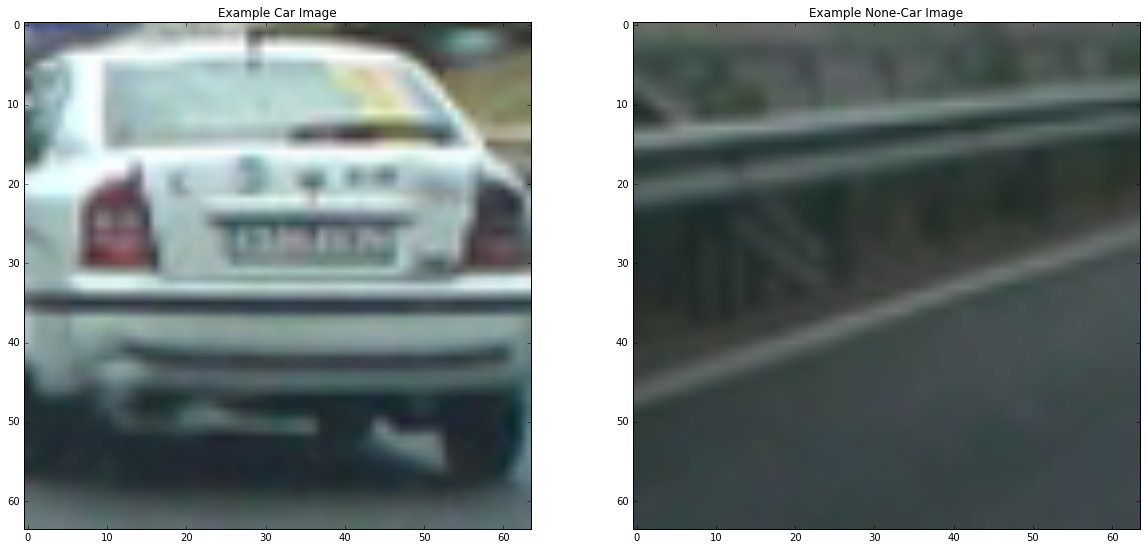

In [5]:
print(len(_cars), len(_notcars))
test_random_car_and_notcar(_cars, _notcars)

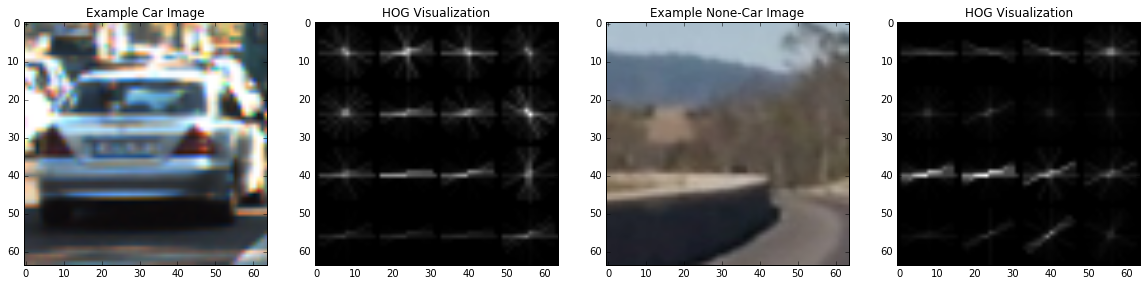

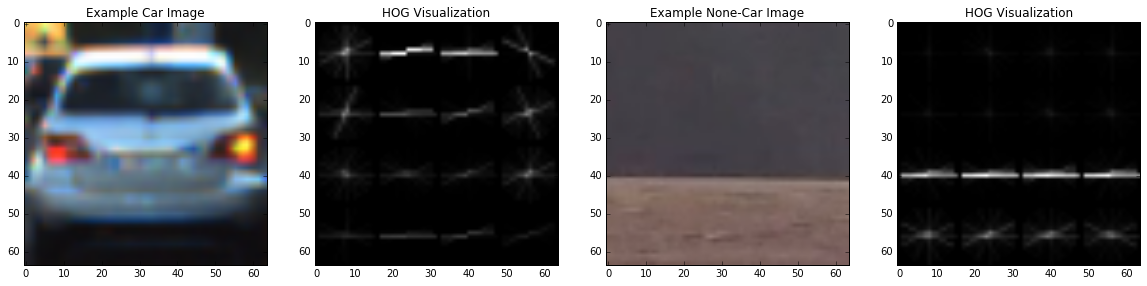

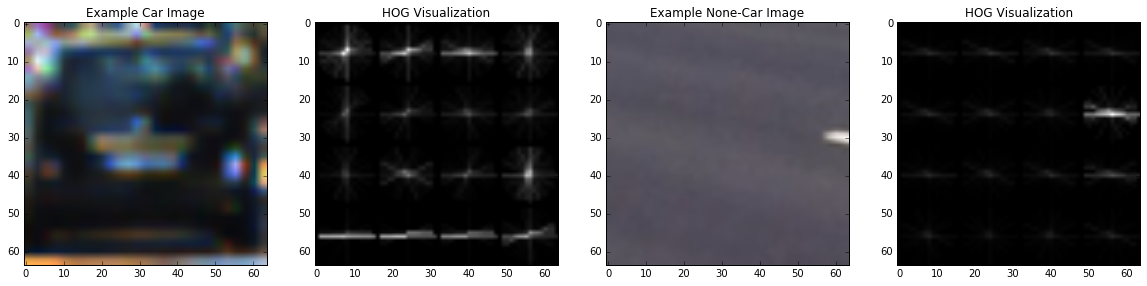

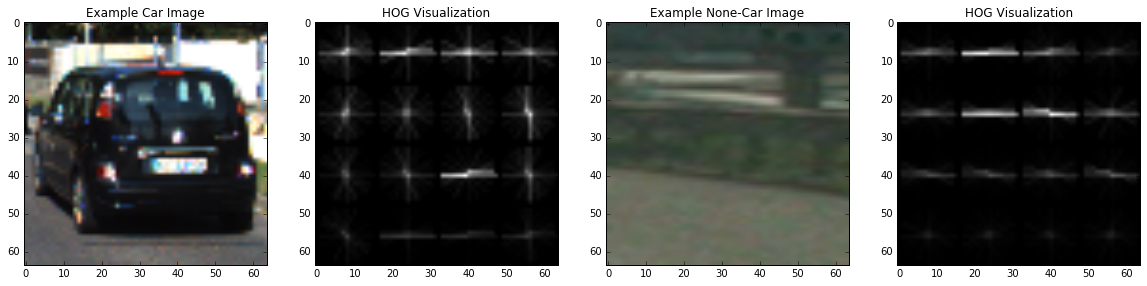

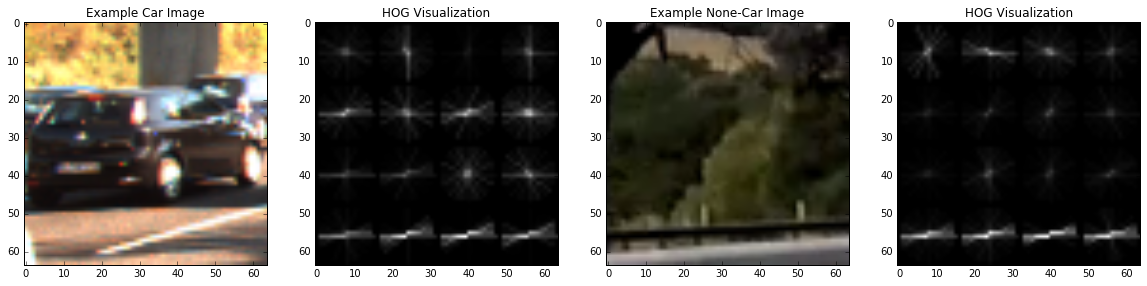

In [6]:
test_hog_random_car_and_notcar(_cars, _notcars, 5)

#### 2. Explain how you settled on your final choice of HOG parameters.

I tried various combinations of parameters and...

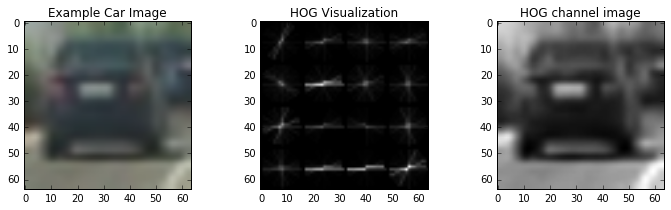

In [7]:
@interact
def test_hog(cars=fixed(_cars), i:(0, len(_cars))=0, orient:(0,32)=ORIENT, pix_per_cell:(8,24)=PIX_PER_CELL, cell_per_block:(1,4) = CELL_PER_BLOCK):
  
    img = mpimg.imread(cars[i])    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ycrcb = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    
    features, hog_img = HogFeatureUtil.get_hog_features(gray, orient, 
                            pix_per_cell, cell_per_block, 
                            vis=True, feature_vec=False)

    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.imshow(img)
    plt.title('Example Car Image')
    plt.subplot(132)
    plt.imshow(hog_img, cmap='gray')
    plt.title('HOG Visualization')
    plt.subplot(133)
    plt.imshow(gray, cmap='gray')
    plt.title('HOG channel image')

#### 3. Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).

I trained a linear SVM using...

In [8]:
""" Train the model using SVM """
_X_scaler, X_train, y_train = HogFeatureUtil.hog_classify(_cars, _notcars, \
            orient=ORIENT, pix_per_cell=PIX_PER_CELL, cell_per_block=CELL_PER_BLOCK)
_svc = LinearSVC()
_svc = Trainer.train(_svc, X_train, y_train)

4.16 Seconds to extract HOG features...
Feature vector length: 3552
0.11 Seconds to train SVC...
Test Accuracy of SVC =  1.0
My SVC predicts:  [ 0.  0.  1.  1.  1.  0.  0.  0.  1.  0.]
For these 10 labels:  [ 0.  0.  1.  1.  1.  0.  0.  0.  1.  0.]
0.0009 Seconds to predict 10 labels with SVC


In [9]:
# Load test images
test_images = VideoUtil.images_from_video('project_video.mp4')

100%|█████████▉| 1260/1261 [00:04<00:00, 281.37it/s]


In [64]:
def init_process_video():
    global _svc
    global _X_scaler
    
    """ Initialize global variables in preparation for processing image frames """
    _X_scaler, X_train, y_train = HogFeatureUtil.hog_classify(_cars, _notcars, \
                orient=ORIENT, pix_per_cell=PIX_PER_CELL, cell_per_block=CELL_PER_BLOCK)
    _svc = LinearSVC()
    _svc = Trainer.train(_svc, X_train, y_train)
    pass


def process_frame(frame_img):    
#    frame_img = frame_img.astype(np.float32)/255   
    ystart = 400
    ystop = 656
    box_list = []
    for i in range(2, 7):
        scale = i * 0.25 # scale: 0.5 ~ 1.5
        boxes, _ = VehicleDetector.find_cars(frame_img, ystart, ystop, scale, svc, X_scaler, \
                orient=ORIENT, pix_per_cell=PIX_PER_CELL, cell_per_block=CELL_PER_BLOCK)
        box_list = box_list + boxes
    out_img, _ = VehicleDetector.apply_heat_map(frame_img, box_list)
#     boxes_img = ImageUtil.draw_boxes(frame_img, box_list)
#     console_img = ImageUtil.image_console(out_img, boxes_img, heatmap, None, None,
#                              None)    
    return out_img

In [65]:
def visualize_find_cars(svc, X_scaler, original_img):
    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    img = original_img.astype(np.float32)/255   
    ystart = 400
    ystop = 656

    box_list = []
    for i in range(2, 8):
        scale = i * 0.25 # scale: 0.5 ~ 1.5
        boxes, _ = VehicleDetector.find_cars(img, ystart, ystop, scale, svc, X_scaler, \
                orient=ORIENT, pix_per_cell=PIX_PER_CELL, cell_per_block=CELL_PER_BLOCK)
        box_list = box_list + boxes
    out_img, heatmap = VehicleDetector.apply_heat_map(original_img, box_list, 1)
    boxes_img = ImageUtil.draw_boxes(original_img, box_list)

    fig = plt.figure(figsize=(12, 36))
    plt.subplot(131)
    plt.imshow(boxes_img)
    plt.title('Detected boxes')
    plt.subplot(132)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    plt.subplot(133)
    plt.imshow(out_img)
    plt.title('Car Positions')    
    fig.tight_layout()    

StandardScaler(copy=True, with_mean=True, with_std=True)
StandardScaler(copy=True, with_mean=True, with_std=True)
StandardScaler(copy=True, with_mean=True, with_std=True)
StandardScaler(copy=True, with_mean=True, with_std=True)
StandardScaler(copy=True, with_mean=True, with_std=True)
StandardScaler(copy=True, with_mean=True, with_std=True)
Skip
Skip
Skip
StandardScaler(copy=True, with_mean=True, with_std=True)
StandardScaler(copy=True, with_mean=True, with_std=True)
StandardScaler(copy=True, with_mean=True, with_std=True)
StandardScaler(copy=True, with_mean=True, with_std=True)
StandardScaler(copy=True, with_mean=True, with_std=True)
StandardScaler(copy=True, with_mean=True, with_std=True)
Skip
Skip
StandardScaler(copy=True, with_mean=True, with_std=True)
StandardScaler(copy=True, with_mean=True, with_std=True)
StandardScaler(copy=True, with_mean=True, with_std=True)
StandardScaler(copy=True, with_mean=True, with_std=True)
StandardScaler(copy=True, with_mean=True, with_std=True)
Standa

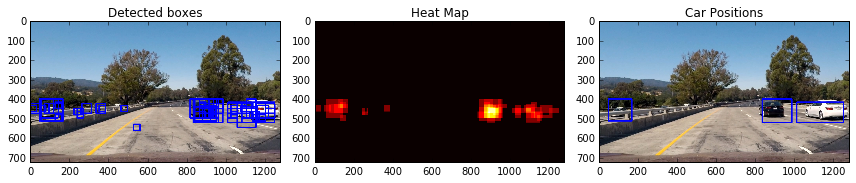

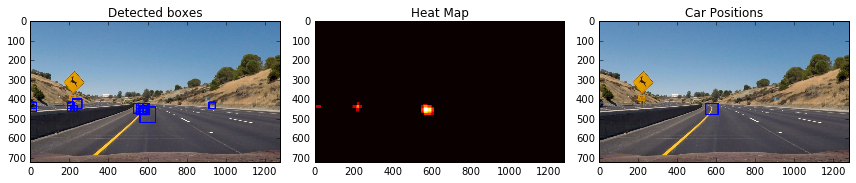

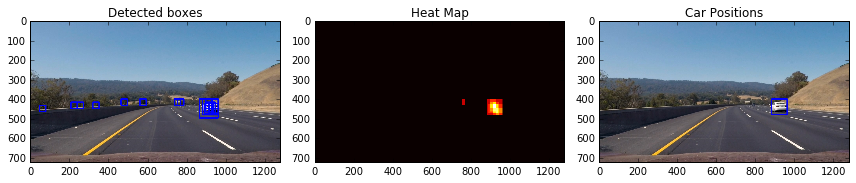

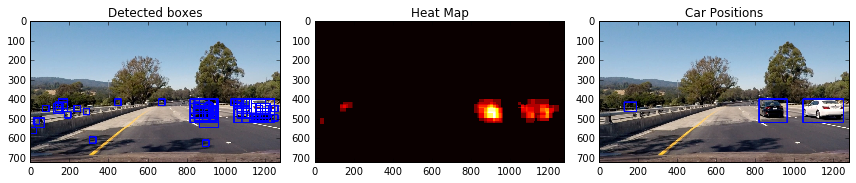

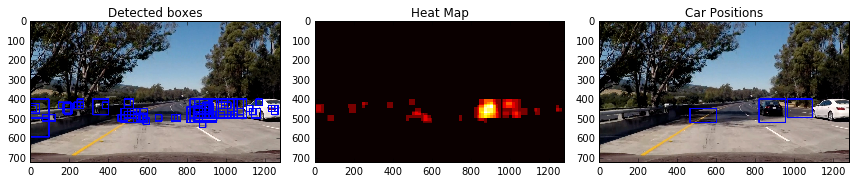

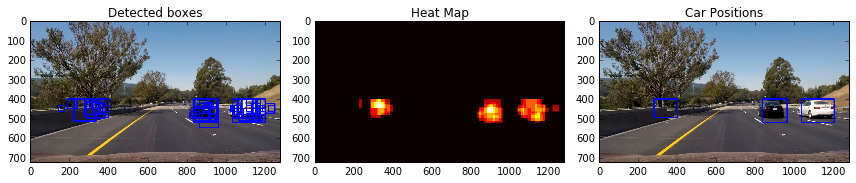

In [66]:
for fname in glob.glob(TEST_IMAGES_PATH):
    original_img = cv2.imread(fname)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    visualize_find_cars(_svc, _X_scaler, original_img)

StandardScaler(copy=True, with_mean=True, with_std=True)
StandardScaler(copy=True, with_mean=True, with_std=True)
StandardScaler(copy=True, with_mean=True, with_std=True)
StandardScaler(copy=True, with_mean=True, with_std=True)
StandardScaler(copy=True, with_mean=True, with_std=True)
StandardScaler(copy=True, with_mean=True, with_std=True)


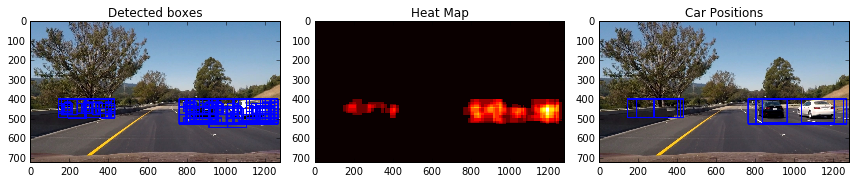

In [67]:
#init_process_video()

@interact
def test_find_cars(images=fixed(test_images), i:(0, len(test_images) - 1)=960):
    file, img = images[i]
    visualize_find_cars(_svc, _X_scaler, original_img)
    


In [14]:
### Process Video

In [15]:
def processVideo(intput_file_name, output_file_name):    
    init_process_video()
    
    clip2 = VideoFileClip(intput_file_name).subclip(20, 20.2)
    #clip2.subclip(frame_start=5, frame_end=15).speedx(2) # works
    clip_handler = clip2.fl_image(process_frame)
    %time clip_handler.write_videofile(output_file_name, audio=False)

In [16]:
# Project video
#processVideo('project_video.mp4', 'project_video_result.mp4')

[//]: # (Image References)
[image1]: ./examples/car_not_car.png
[image2]: ./examples/HOG_example.jpg
[image3]: ./examples/sliding_windows.jpg
[image4]: ./examples/sliding_window.jpg
[image5]: ./examples/bboxes_and_heat.png
[image6]: ./examples/labels_map.png
[image7]: ./examples/output_bboxes.png
[video1]: ./project_video.mp4


### Video Implementation

#### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)
Here's a [link to my video result](./project_video.mp4)


#### 2. Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.

I recorded the positions of positive detections in each frame of the video.  From the positive detections I created a heatmap and then thresholded that map to identify vehicle positions.  I then used `scipy.ndimage.measurements.label()` to identify individual blobs in the heatmap.  I then assumed each blob corresponded to a vehicle.  I constructed bounding boxes to cover the area of each blob detected.  

Here's an example result showing the heatmap from a series of frames of video, the result of `scipy.ndimage.measurements.label()` and the bounding boxes then overlaid on the last frame of video:

### Here are six frames and their corresponding heatmaps:

![alt text][image5]

### Here is the output of `scipy.ndimage.measurements.label()` on the integrated heatmap from all six frames:
![alt text][image6]

### Here the resulting bounding boxes are drawn onto the last frame in the series:
![alt text][image7]


---

### Discussion

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

Here I'll talk about the approach I took, what techniques I used, what worked and why, where the pipeline might fail and how I might improve it if I were going to pursue this project further. 